# Download the data

In this notebook crappifiers functions  will be tested (based on the ones proposed on [1]). For that, we eill need the data they used in electron microscopy (EM), this data can be found on:  https://3dem.org/public-data/tapis/public/3dem.storage.public/2021_Manor_PSSR/

[1] Fang, L., Monroe, F., Novak, S.W. et al. Deep learning-based point-scanning super-resolution imaging. Nat Methods 18, 406–416 (2021). [[paper](https://doi.org/10.1038/s41592-021-01080-z)] [[GitHub](https://github.com/BPHO-Salk/PSSR)]


Links in this [webpage](https://3dem.org/public-data/tapis/public/3dem.storage.public/2021_Manor_PSSR/Main_models/EM/) are volatile, therefore you need to copy the link each time you need to run the following command.

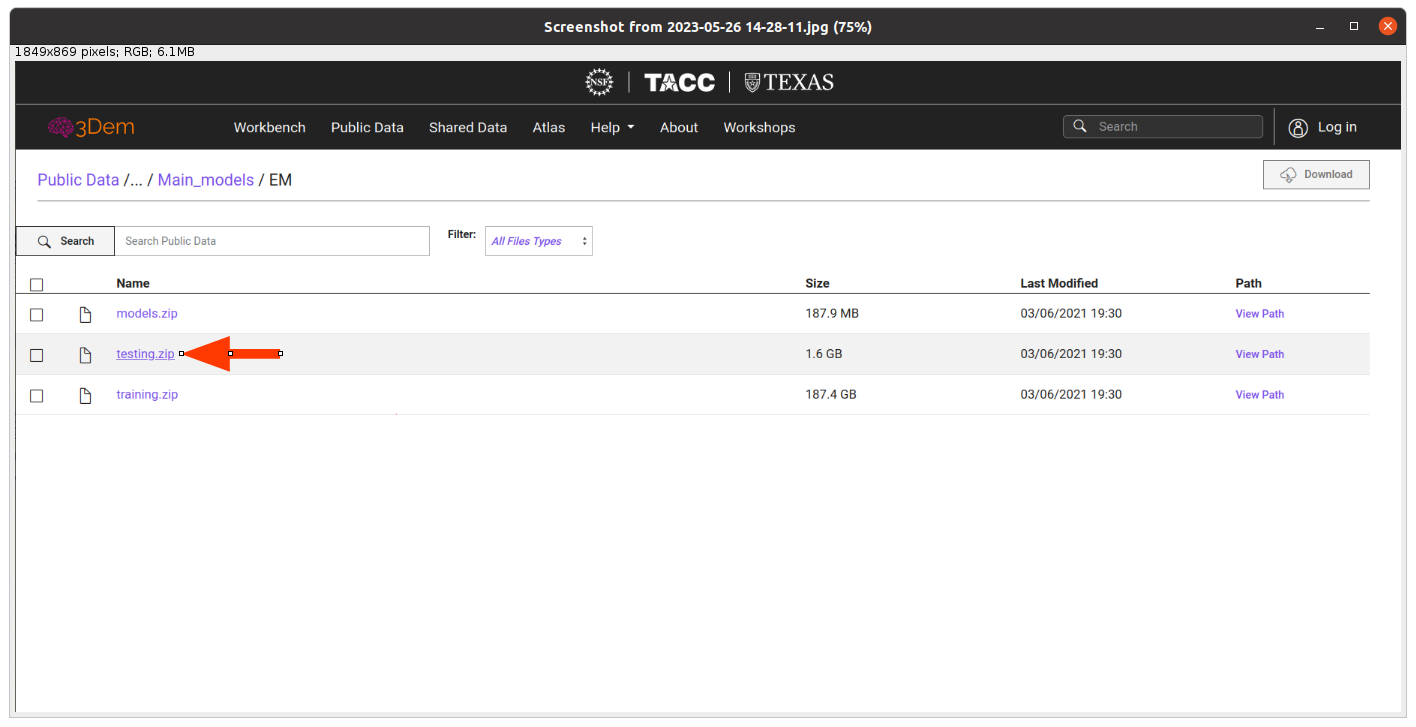

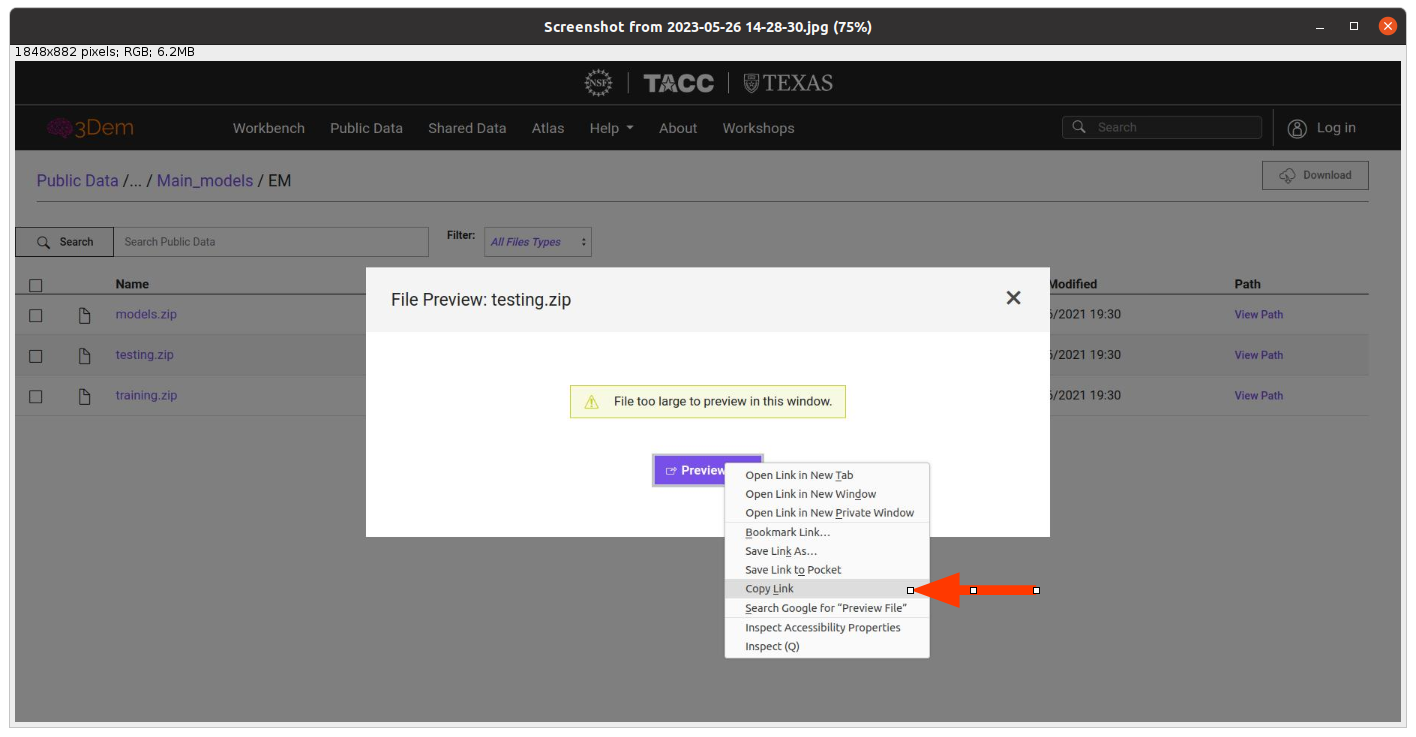

In [ ]:
import os

copied_link = 'https://api.3dem.org/postits/v2/6e3a3cdb-bfd7-44c8-861c-19b433a8bbfe-010' #@param {type:'string'}

os.system(f'wget -O testing.zip {copied_link}')
os.system(f'unzip testing.zip')
os.system(f'rm testing.zip');

In [ ]:
#@markdown # Import and load all the packages and functions

import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import seaborn as sns

from skimage import filters
from skimage import transform
from skimage.util import random_noise
from scipy.ndimage.interpolation import zoom as npzoom
from skimage.transform import rescale

import cv2
from skimage.util import img_as_ubyte, img_as_uint

def compare_pixel_distributions(img1, img2):
  assert img1.dtype==np.ubyte
  assert img2.dtype==np.ubyte

  # Calculate the histograms of the images
  hist1 = cv2.calcHist([img1], [0], None, [256], [0, 256])
  hist2 = cv2.calcHist([img2], [0], None, [256], [0, 256])

  # Normalize the histograms
  hist1_norm = hist1 / np.sum(hist1)
  hist2_norm = hist2 / np.sum(hist2)

  # Calculate the Bhattacharyya coefficient
  bhatt_coeff = np.sqrt(np.sum(np.sqrt(hist1_norm * hist2_norm)))

  # Print the Bhattacharyya coefficient
  return bhatt_coeff

def assert_array_between_zero_and_one(arr):
    assert np.all((0 <= arr) & (arr <= 1)), "Not all values are between 0 and 1"

def normalize(img):
  return (img - img.min())/(img.max() - img.min() + 1e-10)

def add_poisson_noise(img, lam=1.):
    poisson_noise = np.random.poisson(lam=lam, size=img.shape)
    noisy_img = img + norm(poisson_noise)
    return (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())

# Create corresponding training patches synthetically by adding noise
# and downsampling the images (see https://www.biorxiv.org/content/10.1101/740548v3)

def downsampleonly(x, scale=4):
    return npzoom(x, 1/scale, order=1)

def fluo_G_D(x, scale=4):
    x = npzoom(x, 1/scale, order=1)

    mu, sigma = 0, 5
    noise = np.random.normal(mu, sigma*0.05, x.shape)
    x = np.clip(x + noise, 0, 1)

    return x

def fluo_AG_D(x, scale=4):
    x = npzoom(x, 1/scale, order=1)

    lvar = filters.gaussian(x, sigma=5) + 1e-10
    x = random_noise(x, mode='localvar', local_vars=lvar*0.5)

    return x

def fluo_SP_D(x, scale=4):
    x = npzoom(x, 1/scale, order=1)

    x = random_noise(x, mode='salt', amount=0.005)
    x = random_noise(x, mode='pepper', amount=0.005)

    return x

def fluo_SP_AG_D_sameas_preprint(x, scale=4):
    x = npzoom(x, 1/scale, order=1)

    x = random_noise(x, mode='salt', amount=0.005)
    x = random_noise(x, mode='pepper', amount=0.005)
    lvar = filters.gaussian(x, sigma=5) + 1e-10
    x = random_noise(x, mode='localvar', local_vars=lvar*0.5)

    return x

def fluo_SP_AG_D_sameas_preprint_rescale(x, scale=4):
    x = rescale(x, scale=1/scale, order=1, multichannel=len(x.shape) > 2)

    x = random_noise(x, mode='salt', amount=0.005)
    x = random_noise(x, mode='pepper', amount=0.005)
    lvar = filters.gaussian(x, sigma=5) + 1e-10
    x = random_noise(x, mode='localvar', local_vars=lvar*0.5)

    return x

def em_AG_D_sameas_preprint(x, scale=4):
    x = npzoom(x, 1/scale, order=1)

    lvar = filters.gaussian(x, sigma=3) + 1e-10
    x = random_noise(x, mode='localvar', local_vars=lvar*0.05)

    return x

def em_G_D_001(x, scale=4):
    x = npzoom(x, 1/scale, order=1)

    noise = np.random.normal(0, 3, x.shape)
    x = x + noise
    x = x - x.min()
    x = x/x.max()

    return x

def em_G_D_002(x, scale=4):
    x = npzoom(x, 1/scale, order=1)

    mu, sigma = 0, 3
    noise = np.random.normal(mu, sigma*0.05, x.shape)
    x = np.clip(x + noise, 0, 1)

    return x

def em_P_D_001(x, scale=4):
    x = npzoom(x, 1/scale, order=1)
    x = random_noise(x, mode='poisson', seed=1)

    return x

def new_crap_AG_SP(x, scale=4):
    x = rescale(x, scale=1/scale, order=1, multichannel=len(x.shape) > 2)

    lvar = filters.gaussian(x, sigma=5) + 1e-10
    x = norm(x)
    x = random_noise(x, mode='localvar', local_vars=lvar*0.5)

    x = random_noise(x, mode='salt', amount=0.005)
    x = random_noise(x, mode='pepper', amount=0.005)

    return x

def new_crap(x, scale=4):
    x = rescale(x, scale=1/scale, order=1, multichannel=len(x.shape) > 2)

    x = random_noise(x, mode='salt', amount=0.005)
    x = random_noise(x, mode='pepper', amount=0.005)
    lvar = filters.gaussian(x, sigma=5) + 1e-10
    x = random_noise(x, mode='localvar', local_vars=lvar*0.5)

    return x

# Create corresponding training patches synthetically by adding noise
# and downsampling the images (see https://www.biorxiv.org/content/10.1101/740548v3)
def em_crappify(img, scale):
    img = transform.resize(img, (img.shape[0]//scale, img.shape[1]//scale), order=1)

    img = filters.gaussian(img, sigma=3) + 1e-10
    img = norm(img)
    #return npzoom(img, 1/scale, order=1)
    return img

def fluo_crappify(img,scale):
    img = transform.resize(img, (img.shape[0]//scale, img.shape[1]//scale), order=1)

    img = random_noise(img, mode='salt', amount=0.005)
    img = random_noise(img, mode='pepper', amount=0.005)
    img = filters.gaussian(img, sigma=5) + 1e-10
    img = norm(img)
    #return npzoom(img, 1/scale, order=1)
    return img

def em_poisson_crappify(img, scale, lam=1.):
    img = transform.resize(img, (img.shape[0]//scale, img.shape[1]//scale), order=1)

    img = filters.gaussian(img, sigma=2) + 1e-10
    img = norm(img)
    img = add_poisson_noise(img, lam=lam)
    return img

def fluo_poisson_crappify(img,scale, lam=1.):
    img = transform.resize(img, (img.shape[0]//scale, img.shape[1]//scale), order=1)

    img = filters.gaussian(img, sigma=2) + 1e-10
    img = norm(img)
    img = random_noise(img, mode='salt', amount=0.005)
    img = random_noise(img, mode='pepper', amount=0.005)
    img = add_poisson_noise(img, lam=lam)
    return img

def apply_crappifier(x, scale, crappifier_name):
    crappifier_dict = { 'downsampleonly':downsampleonly,
                        'fluo_G_D':fluo_G_D,
                        'fluo_AG_D':fluo_AG_D,
                        'fluo_SP_D':fluo_SP_D,
                        'fluo_SP_AG_D_sameas_preprint':fluo_SP_AG_D_sameas_preprint,
                        'fluo_SP_AG_D_sameas_preprint_rescale':fluo_SP_AG_D_sameas_preprint_rescale,
                        'em_AG_D_sameas_preprint':em_AG_D_sameas_preprint,
                        'em_G_D_001':em_G_D_001,
                        'em_G_D_002':em_G_D_002,
                        'em_P_D_001':em_P_D_001,
                        'new_crap_AG_SP':new_crap_AG_SP,
                        'new_crap':new_crap,
                        'em_crappify':em_crappify,
                        'fluo_crappify':fluo_crappify,
                        'em_poisson_crappify':em_poisson_crappify,
                        'fluo_poisson_crappify':fluo_poisson_crappify,
                      }

    if crappifier_name in crappifier_dict:
        return crappifier_dict[crappifier_name](x, scale).astype(np.float32)
    else:
        raise ValueError('The selected `{}` crappifier_name is not in: {}'.format(crappifier_name, crappifier_dict.keys))



# Inspect paired data
Let's look at the **PAIRED data** that we have downloaded. There are 3 different options to **show**: image, distribution and data.

In [ ]:
#@markdown

hr_path = '/content/testing/HR/real-world_SEM/'#@param ['/content/testing/HR/semi-synthetic_tSEM', '/content/testing/HR/real-world_SEM/']
lr_path = '/content/testing/LR/real-world_SEM/'#@param ['/content/testing/LR/semi-synthetic_tSEM', '/content/testing/LR/real-world_SEM/']

hr_path_list = [os.path.join(hr_path, e) for e in sorted(os.listdir(hr_path))]
lr_path_list = [os.path.join(lr_path, e) for e in sorted(os.listdir(lr_path))]

###
# Select what you want to show below
###
show = 'image'#@param ['image', 'distribution', 'data']

for idx in range(len(hr_path_list)):

  _hr_img = io.imread(hr_path_list[idx]) # normalize(io.imread(hr_path_list[idx]))
  _lr_img = io.imread(lr_path_list[idx]) # normalize(io.imread(lr_path_list[idx]))

  # Then we downscale the GT (HR) image so that is the same shape as WF (LR) one
  _downsampled_hr_img = npzoom(_hr_img, _lr_img.shape[0]/_hr_img.shape[0], order=1) # normalize(npzoom(_hr_img, _lr_img.shape[0]/_hr_img.shape[0], order=1))

  # Assert that all are normalized
  # assert_array_between_zero_and_one(_hr_img)
  # assert_array_between_zero_and_one(_lr_img)
  # assert_array_between_zero_and_one(_downsampled_hr_img)

  # Load as Ubytes (0, 256) all th e previous images
  hr_img = img_as_ubyte(_hr_img)
  lr_img = img_as_ubyte(_lr_img)
  downsampled_hr_img = img_as_ubyte(_downsampled_hr_img)

  # print(f'hr_img - {hr_img.shape} - {hr_img.min()} {hr_img.max()}')
  # print(f'lr_img - {lr_img.shape} - {lr_img.min()} {lr_img.max()}')
  # print(f'downsampled_hr_img - {downsampled_hr_img.shape} - {downsampled_hr_img.min()} {downsampled_hr_img.max()}')

  cmap = 'inferno'

  if show == 'image':
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(lr_img, cmap, vmin=-1, vmax=255)
    plt.title('Low resolution')
    plt.subplot(1,4,2)
    plt.imshow(hr_img, cmap, vmin=-1, vmax=255)
    plt.title('High resolution')
    plt.subplot(1,4,3)
    plt.imshow(downsampled_hr_img, cmap, vmin=-1, vmax=255)
    plt.title('High resolution\ndownsampled')
    plt.subplot(1,4,4)
    plt.imshow(lr_img - downsampled_hr_img, cmap, vmin=-1, vmax=255)
    plt.title('Difference')
    plt.suptitle(hr_path_list[idx])
    plt.show()
  elif show == 'distribution':
    fig, axes = plt.subplots(1, 4, figsize=(20,5))
    sns.histplot(ax=axes[0], data=(_downsampled_hr_img).flatten(), label='down_hr', bins=50)
    sns.histplot(ax=axes[0], data=(_lr_img).flatten(), label='lr', bins=50)
    sns.histplot(ax=axes[1], data=(_lr_img - _downsampled_hr_img).flatten(), label='difference', bins=50)
    sns.histplot(ax=axes[2], data=(downsampled_hr_img).flatten(), label='down_hr', bins=50)
    sns.histplot(ax=axes[2], data=(lr_img).flatten(), label='lr', bins=50)
    sns.histplot(ax=axes[3], data=(lr_img - downsampled_hr_img).flatten(), label='difference', bins=50)
    axes[0].legend()
    axes[0].set_title('Distributions of the images')
    # axes[1].set_xlim(-0.5,0.5)
    axes[1].legend()
    axes[1].set_title('Difference between LR and downsampled HR')
    axes[2].legend()
    axes[2].set_title('Distributions of the images (uint8)')
    axes[3].legend()
    axes[3].set_title('Difference between LR and downsampled HR (uint8)')
    plt.suptitle(hr_path_list[idx])
    plt.show()
  elif show == 'data':
    print(f'mean: {np.mean(lr_img - downsampled_hr_img):.3f} \tstd: {np.std(lr_img - downsampled_hr_img):.3f}  \tmin: {np.min(lr_img - downsampled_hr_img):.3f}  \tmax: {np.max(lr_img - downsampled_hr_img):.3f}')



# --- Things that I have discovered during this notebook ---

This notebook is the result of numerous tests, making it remarkably straightforward. However, in the following, I will meticulously elucidate all the steps and discoveries I have made during the process.

## Data type

First of all, the data type from the original images --> they are ubytes (0-255 values).

One problem comes with the noramilzation, even if those values are normalized between 0 and 1, they will stay in a discrete range of values, but in this case those values will be float numbers. In the images bellow you can see how a histogram with enough amount of bins will show this:

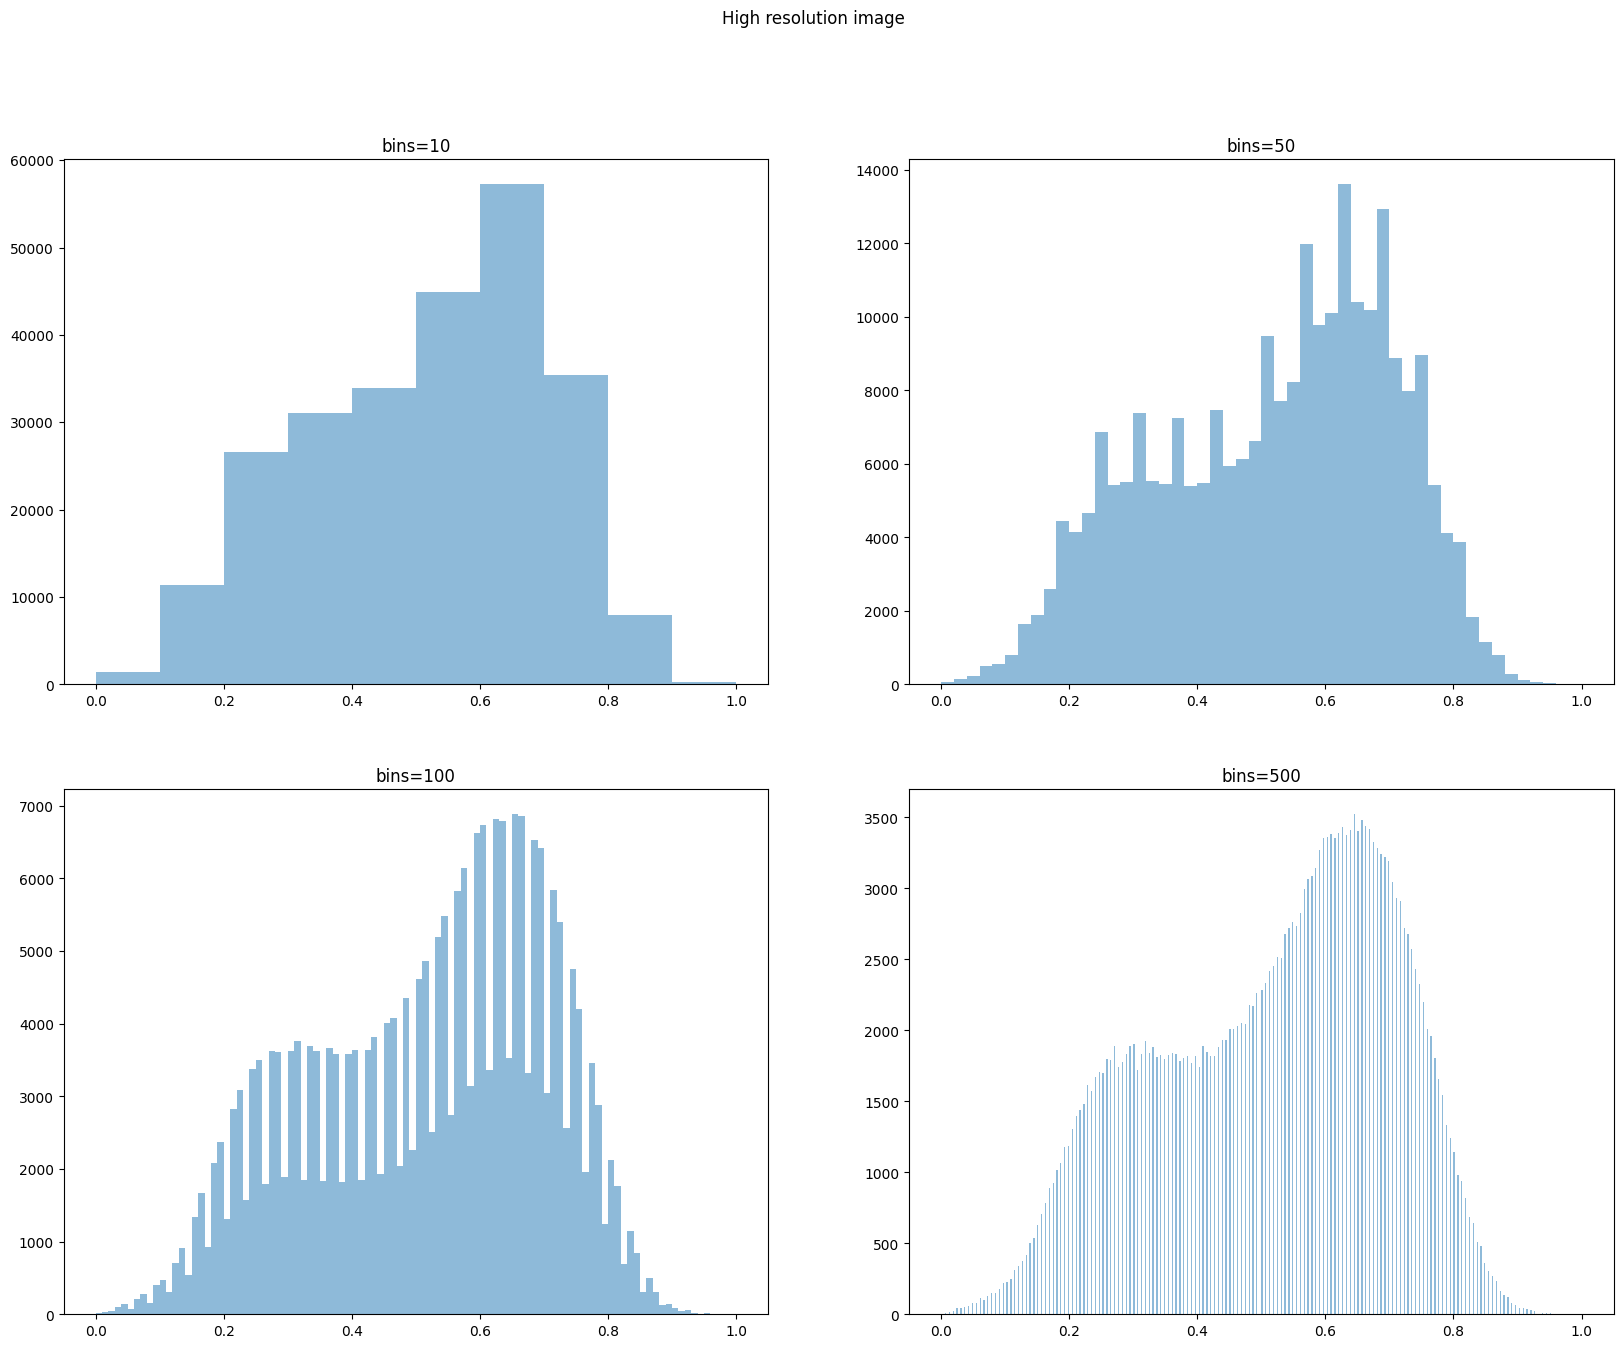

The following image compare the real LR image with ubyte values (orange bins) and the downsampled HR image (which has been downsampled using bilinear interpolation and therefore has really continuous values):

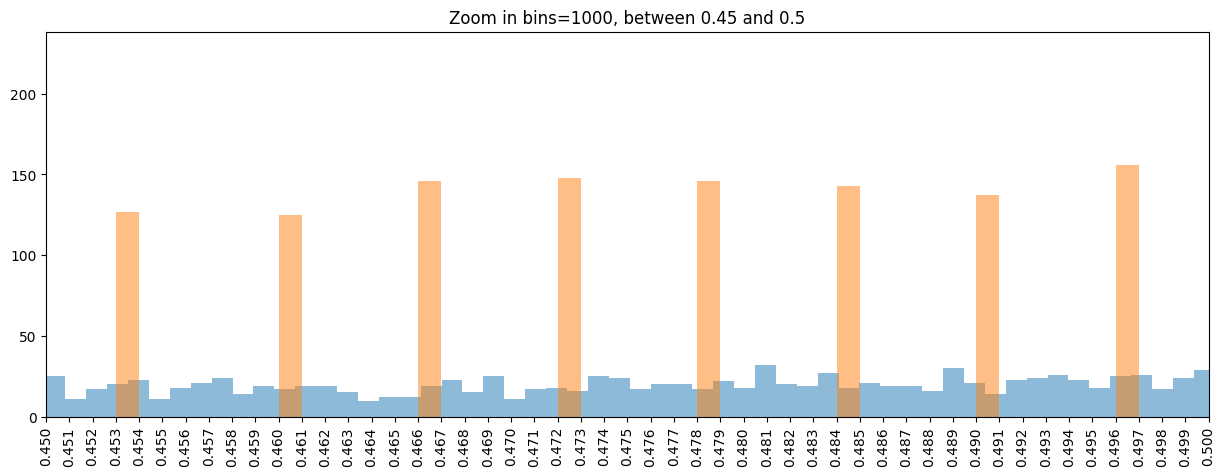


As it can be seen in the previous image, due to the discrete values from the real image, there will allways be a minimal error of those values that do not exist in the real image.

A solution that I thought was t o make the comparison in the same data type. As the real image do not work well in the continuous domain, my idea was to compare them in the discrete domain (parsing the downsampled HR image or the crappified image to ubyte dtype).

## Carefull with **ubyte** operations

Here there is a problem that has to be taken into account: the ubyte values perform different to integer values. With integer values:
```
250 + 40 = 290
```
But with ubyte values:
```
250 + 40 = 34
```
This happens because there can not be a value out of the ragne [0, 255], therefore if a mathematical opperation that makes a ubyte value get out of that range, it will be recalculated to stay in that range (add 255 if is bellow 0 or substract 255 if surpasses 255).

## What to do?

So in order to compare two images, two different things can be done. Admit that small error in case you want to make the comparison with normalized values. Or follow the next steps to ensure that the comparison is correctly done:


1.   Load or calculate all the images that will be compared (normalized if it is possible).
2.   Then, parse the images to ubytes in case they were not in that domain.
3. Once the values are discrete, normalize those values in order to make the comparison (with this all the valeus will be normalized but as float valeus, avoinding the strange perfomrances).
4. Compare the images with mse or by looking at the histograms.

## Compare the images

### Based on a classic image analysis metric

My first idea to compare two images was applying the mse, but as the noise in the images was random and it makes a pixel-based comparison, I did not know if it was a great option.

Therefore a better option was to use structured similarity index measure (SSIM), as it is explained [here](https://videoprocessing.ai/metrics/ways-of-cheating-on-popular-objective-metrics.html).

The idea here is to compare the real LR image with the crappified image. Therefore an initial idea is to calculate the SSIM of the real LR image and the crappified image.

### Based on the histogram

But there is also the point of view where the only thing we want to calculate is the noise that is added to the downsampled HR image in order to be close to the real LR image. In this perspective what we would do was to substract the real LR image with the downsampled HR image and to substract the crappified image with the downsampled HR image.




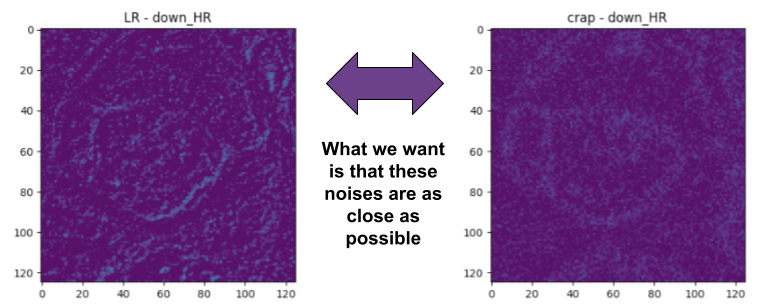

Therefore as that is the noise we need to replicate or achieve, a possible solution would be to compare those noises. They can be compared based on the image itself or by looking at their histograms and see how close those histograms are.

The problem here is that even if the noise distributions look similar, their images might not be the same:

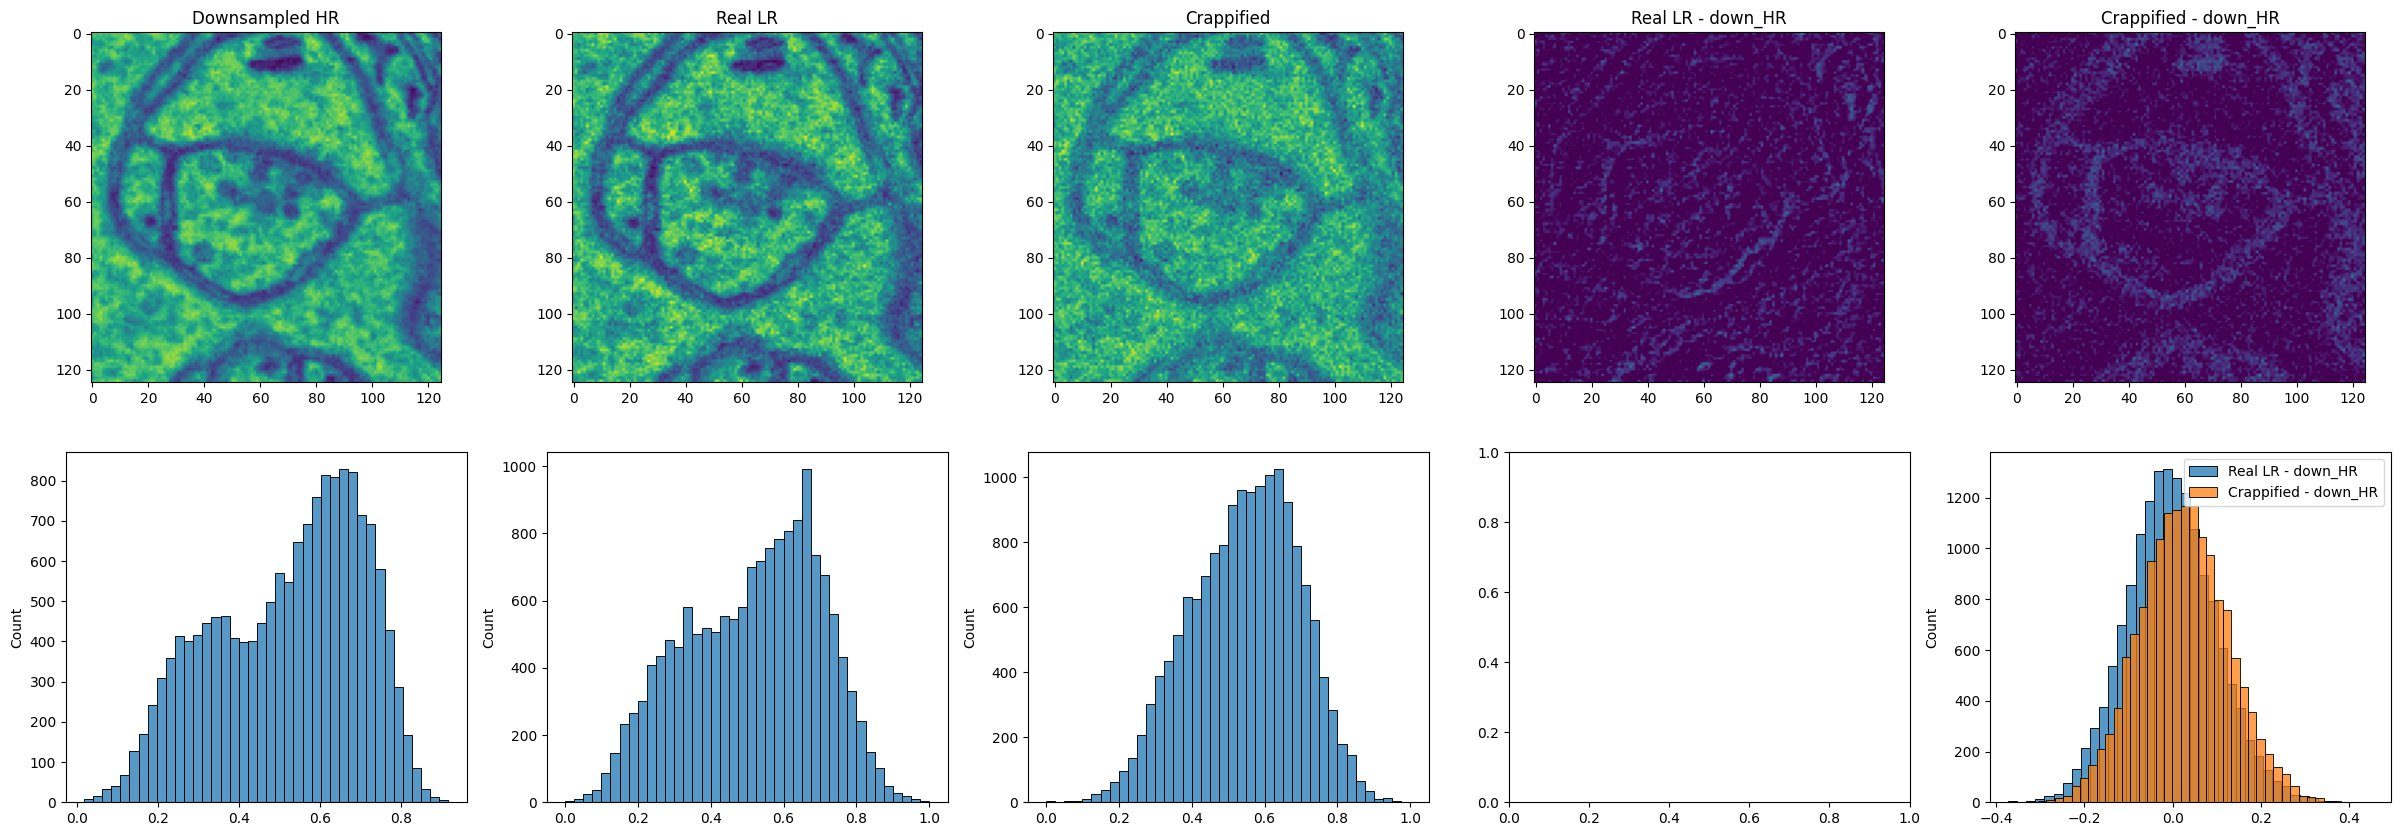

In the previous case, you can see how in the probability distribution of the noises are very close but the **Real LR** image and the **Crappified** images are not very similar and their distributions neither.

This might ve because of how the noise is distribution. In the real LR image, the noise might be distributed based on the sample and the microscopy. But in the drappified image, our noise is uniformly distributed and that is what makes the difference between the two images.

# Let's take all the differences from all the images

In [ ]:
from skimage.metrics import structural_similarity as ssim

def norm_gaussian_crappify(x, mu, sigma, scalar=1, scale=4):
    x = normalize(npzoom(x, 1/scale, order=1))
    noise = np.random.normal(mu, sigma,  x.shape)
    x = normalize(x + scalar * noise)
    return x

def norm_compare_2_distr(data1, data2):
  bins1, _, __ = plt.hist(data1.flatten(), bins=50, range=(-1,1), density=True)
  bins2, _, __ = plt.hist(data2.flatten(), bins=50, range=(-1,1), density=True)
  plt.close()
  # plt.show()
  return np.sum(np.abs(bins1 - bins2))

hr_path = '/content/testing/HR/real-world_SEM/'#@param ['/content/testing/HR/semi-synthetic_tSEM', '/content/testing/HR/real-world_SEM/']
lr_path = '/content/testing/LR/real-world_SEM/'#@param ['/content/testing/LR/semi-synthetic_tSEM', '/content/testing/LR/real-world_SEM/']

hr_path_list = [os.path.join(hr_path, e) for e in sorted(os.listdir(hr_path))]
lr_path_list = [os.path.join(lr_path, e) for e in sorted(os.listdir(lr_path))]

# Compare different combinations of guassian noise:

In [ ]:
results = {}

for mu in np.arange(-1.0,1.0,0.4): # -0.2,0.2,0.05
  for sigma in np.arange(0.0,1.0,0.4): # 0.1,0.2,0.05
    for scalar in np.arange(0.0,1.0,0.4): # 0.1,1.0,0.1
      sum_error_distributions = 0
      sum_images_distributions = 0
      sum_ssim = 0
      for idx in range(len(hr_path_list)):
        _hr_img = normalize(io.imread(hr_path_list[idx]))
        _lr_img = normalize(io.imread(lr_path_list[idx]))

        # Then we downscale the GT (HR) image so that is the same shape as WF (LR) one
        _downsampled_hr_img = npzoom(_hr_img, _lr_img.shape[0]/_hr_img.shape[0], order=1)
        _crap_img = norm_gaussian_crappify(_hr_img, mu, sigma, scalar)

        _hr_img = normalize(img_as_ubyte(_hr_img))
        _lr_img = normalize(img_as_ubyte(_lr_img))
        _downsampled_hr_img = normalize(img_as_ubyte(_downsampled_hr_img))
        _crap_img = normalize(img_as_ubyte(_crap_img))

        # assert_array_between_zero_and_one(_hr_img)
        # assert_array_between_zero_and_one(_lr_img)
        # assert_array_between_zero_and_one(_downsampled_hr_img)
        # assert_array_between_zero_and_one(_crap_img)

        diff = _lr_img - _downsampled_hr_img
        crap_diff = _crap_img - _downsampled_hr_img

        sum_error_distributions += norm_compare_2_distr(diff, crap_diff)
        sum_images_distributions += norm_compare_2_distr(_lr_img, _crap_img)
        sum_ssim += ssim(_lr_img, _crap_img)

      results[f'mu={mu}_sigma={sigma}_scalar_{scalar}'] = [sum_error_distributions, sum_images_distributions, sum_ssim]

In [ ]:
ranking = {}

print('Sorted based on error distribution differences:')
cont = 0
for k, v in sorted(results.items(), key=lambda item: item[1][0]):
  ranking[k] = [cont]
  if cont <= 10:
    print(f'{k} -> {v}')
  cont += 1

print()
print('Sorted based on error distribution differences:')
cont = 0
for k, v in sorted(results.items(), key=lambda item: item[1][1]):
  ranking[k].append(cont)
  if cont <= 10:
    print(f'{k} -> {v}')
  cont += 1

print()
print('Sorted based on ssim:')
cont = 0
for k, v in sorted(results.items(), key=lambda item: item[1][2]):
  ranking[k].append(cont)
  if cont <= 10:
    print(f'{k} -> {v}')
  cont += 1

ranking_sum = {k:np.sum(v) for k,v in ranking.items()}

print()
print('Ranking:')
cont = 0
for k, v in sorted(ranking_sum.items(), key=lambda item: item[1]):
  print(f'{k} -> {v} : {ranking_sum[k]}')
  if cont >= 10:
    break
  cont += 1

## Visualize a specific guassian noise combination

In [ ]:
mu = 0.1
sigma = 0.15
scalar = 0.9

for idx in range(len(hr_path_list)):

  _hr_img = normalize(io.imread(hr_path_list[idx]))
  _lr_img = normalize(io.imread(lr_path_list[idx]))

  # Then we downscale the GT (HR) image so that is the same shape as WF (LR) one
  _downsampled_hr_img = npzoom(_hr_img, _lr_img.shape[0]/_hr_img.shape[0], order=1)

  noise = np.random.normal(mu, sigma, (125,125))

  _crap_img = norm_gaussian_crappify(_hr_img, mu, sigma, scalar)

  diff = _lr_img - _downsampled_hr_img
  crap_diff = _crap_img - _downsampled_hr_img

  fig, axes = plt.subplots(2, 5, figsize=(30,10))
  axes[0,0].imshow(_downsampled_hr_img, vmin=0, vmax=1)
  axes[0,0].set_title('Downsampled HR')
  axes[0,1].imshow(_lr_img, vmin=0, vmax=1)
  axes[0,1].set_title('Real LR')
  axes[0,2].imshow(_crap_img, vmin=0, vmax=1)
  axes[0,2].set_title('Crappified')
  axes[0,3].imshow(diff, vmin=0, vmax=1)
  axes[0,3].set_title('Real LR - down_HR')
  axes[0,4].imshow(crap_diff, vmin=0, vmax=1)
  axes[0,4].set_title('Crappified - down_HR')
  sns.histplot(ax=axes[1,0], data=(_downsampled_hr_img).flatten(), bins=40, label='real')
  sns.histplot(ax=axes[1,1], data=(_lr_img).flatten(), bins=40, label='real')
  sns.histplot(ax=axes[1,2], data=(_crap_img).flatten(), bins=40, label='real')
  sns.histplot(ax=axes[1,4], data=(diff).flatten(), bins=40, label='Real LR - down_HR')
  sns.histplot(ax=axes[1,4], data=(crap_diff).flatten(), bins=40, label='Crappified - down_HR')
  axes[1,4].legend()
  plt.show()

  if idx > 10:
    break